In [1]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from scipy import stats
from copy import deepcopy
from datetime import datetime
from WindPy import w
w.start()



#############输入模型参数#################

#感兴趣的指数，例如上证综合指数，南化综合指数，中债国开债10年与1年收益率
int_list = [['M0020188','股票'],['S0105896','商品'],['M1004271','10债'],['M1004263','1债']]

#起止时间
t0 = '2004-06-01'
t1 = '2020-08-01'

#指数取值周期
dic = {'D':'天', 'W':'周', 'M':'月', 'Q':'季度', 'S':'半年', 'Y':'年'}
prd = 'W'

#计算原趋势、反转、现趋势的周期跨度，第一次现趋势修正跨度，第二次现趋势修正跨度
itv = 8
itv2 = 4
itv3 = 4

#不同市场第一次现趋势修正分位数
dic_market = {'股票':.5, '商品':.5, '10债':.1, '1债':0}

#新趋势出现判断（选用黄金分割比值）
n = 0.618

#是否绘制图像
pt = 1

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


# 取得指数基础信息与趋势修正的函数

In [2]:
def mod(int_list, t0, t1, prd, itv, itv2, itv3, dic_market, n, pt):
    
    plt.rcParams['font.family']=['SimHei']
    
    ind_list = []
    for i in int_list:
        ind_list.append(i[0])
    
    #从WIND读取数据
    whole_df = w.wsd(ind_list, 'close', t0, t1, Period = prd, Fill = 'Previous').Data
    date = w.wsd(ind_list, 'close', t0, t1, Period = prd, Fill = 'Previous').Times
    
    l = len(whole_df[0])
    
    res = []
    
    for x in range(len(whole_df)):
        
        m = dic_market[int_list[x][1]]
        
        if pt == 1:
            #基础可视化
            plt.figure(figsize=(15,8))
            plt.plot(date, whole_df[x])
            plt.title(str(date[0])+'至'+str(date[-1])+'间'+ind_list[x]+dic[prd]+'指数',fontproperties='SimHei', size = 20)
            plt.show()

        #在周期跨度itv内：
        trend = l * [0]         #原趋势
        sig = l * [0]           #反转
        newtrend = l * [0]      #现趋势  

        for i in range(itv, l):

            #选取周期跨度itv内的数据
            df_i = whole_df[x][i-itv:i+1]

            #得出周期跨度itv内的极值与坐标
            _max = max(df_i)
            _min = min(df_i)
            id_max = df_i.index(_max)
            id_min = df_i.index(_min)

            #根据极值与坐标得出该周期的原趋势
            trend[i] = -(-1) ** int(id_max > id_min)

            #与前个周期的原趋势对比得出是否反转，以及反转方向
            sig[i] = int(trend[i] != trend[i-1]) * -(-1) ** int(trend[i] > trend[i-1])

            #根据周期内最后指数和极值，判断现趋势的方向，此处使用黄金分割比值n = 0.618
            if trend[i] == -1:
                newtrend[i] = -(-1) ** (((whole_df[x][i]-_min)/(_max-_min)) > n)
            else:
                newtrend[i] = (-1) ** (((_max-whole_df[x][i])/(_max-_min)) > n)

        col = ['r', 'b']
        if pt == 1:
            #原趋势图像
            plt.figure(figsize=(15,8))
            plt.plot(date, whole_df[x], c='black', linewidth = .3)
            plt.scatter(date, whole_df[x], c = [col[0] if i == 1 else col[1] for i in trend], s = 3)
            plt.title(str(date[0])+'至'+str(date[-1])+'间'+ind_list[x]+dic[prd]+'指数原趋势', size = 20)
            plt.show()

            #反转图像
            plt.figure(figsize=(15,8))
            plt.plot(date,whole_df[x],c='black', linewidth = .3)
            plt.scatter(date, whole_df[x], c = [col[0] if i == 1 else col[1] for i in sig], s = [15 if i != 0 else 0 for i in sig])
            plt.title(str(date[0])+'至'+str(date[-1])+'间'+ind_list[x]+dic[prd]+'指数每周期内反转状况', size = 20)
            plt.show()

            #现趋势图像
            plt.figure(figsize=(15,8))
            plt.plot(date,whole_df[x],c='black', linewidth = .3)
            plt.scatter(date, whole_df[x], c = [col[0] if i == 1 else col[1] for i in newtrend], s = 3)
            plt.title(str(date[0])+'至'+str(date[-1])+'间'+ind_list[x]+dic[prd]+'指数每周期内现趋势', size = 20)
            plt.show()

        #现趋势涨幅第一次修正

        trend_cor = deepcopy(newtrend)  

        for i in range(100, l):
            #第一所选区间，与极值
            df_i = whole_df[x][i-itv2+1:i+1]
            _min = min(df_i)
            _max = max(df_i)

            #周期末指数与极值的比例
            now = whole_df[x][i]/[_min,_max][newtrend[i] == -1]-1
            s = []

            for j in range(itv2,i):
                #第一所选区间100天以内的第二所选区间，与极值
                df_j = whole_df[x][j-itv2:j]
                j_min = min(df_j)
                j_max = max(df_j)

                #第二所选区间的现趋势
                t = newtrend[j-itv2:j]

                #若所选现趋势区间内现趋势恒定，则在表中添加第二所选区间极值函数，最多添加100-itv2次
                if abs(sum(t)) == itv2:
                    s.append([j_min,j_max][newtrend[i] == 1]/[j_min,j_max][newtrend[i] == -1]-1)

            #若周期末指数与极值的比例，超过或低于，100天内现趋势恒定的极值函数列表内 一定分位数水平，则当前现趋势修正为上个周期的现趋势      
            if newtrend[i] == 1 and now < np.quantile(s, m):
                trend_cor[i] = trend_cor[i-1] 
            elif newtrend[i] == -1 and now > np.quantile(s, 1-m):
                trend_cor[i] = trend_cor[i-1] 

        cor1 = deepcopy(trend_cor)

        print(ind_list[x],'第一次现趋势修正占比=', round(sum([trend_cor[i] != newtrend[i] for i in range(len(newtrend))])/len(newtrend),3))

        if pt == 1:
            #第一次现趋势修正部分图像
            plt.figure(figsize=(15,8))
            plt.plot(date,whole_df[x],c='black', linewidth = .3)
            plt.scatter(date, whole_df[x], c = [col[0] if i == 1 else col[1] for i in trend_cor],
                        s = [40 if trend_cor[i] != newtrend[i] else .3 for i in range(l)])
            plt.title(str(date[0])+'至'+str(date[-1])+'间'+ind_list[x]+dic[prd]+'指数每周期内现趋势第一次修正部分', size = 20)
            plt.show()

        #现趋势涨幅第二次修正，itv3 = 4

        pos = 1
        while pos < l-1:
            step = 1
            if abs(sum(trend_cor[pos-1:pos+2])) == 3:  #[1,1,1]，移动到第四周期
                pos += 2

            elif trend_cor[pos] * trend_cor[pos-1] + trend_cor[pos] * trend_cor[pos+1] == -2: #[1,-1,1]，将中间的现趋势修正，移动到第四周期
                trend_cor[pos] = trend_cor[pos-1]
                pos += 2

            elif trend_cor[pos] * trend_cor[pos-1] + trend_cor[pos] * trend_cor[pos+1] == 0:  #[1,1,-1]，移动到第三个周期
                pos += 1

            else:  #[1,-1,-1]，在相同的现趋势达到3（itv3-1）个前，尽可能多的修正中间的现趋势
                if abs(sum(trend_cor[pos-1:pos+itv3])) == itv3-1:  #[1, -1, -1, -1, -1]，连续（itv3-1）个周期不变，移动到第（itv3+2）周期
                    pos += itv3

                else: #[1, -1, -1, 1] 或 [1, -1, -1, -1, 1]，将中间2或3个周期的现趋势修正，并移动到第五或第六周期处
                    while step < itv3 and trend_cor[pos+step] != trend_cor[pos-1]:
                        trend_cor[pos+step-1] = trend_cor[pos-1]
                        step += 1
                    pos += step

        #trend_cor为修正后的现趋势


        print(ind_list[x],'第二次现趋势修正占比=', round(sum([trend_cor[i] != cor1[i] for i in range(len(trend_cor))])/len(trend_cor),3))

        if pt == 1:
            #第二次现趋势修正部分图像
            plt.figure(figsize=(15,8))
            plt.plot(date,whole_df[x],c='black', linewidth = .3)
            plt.scatter(date, whole_df[x], c = [col[0] if i == 1 else col[1] for i in trend_cor],
                        s = [30 if trend_cor[i] != cor1[i] else .3 for i in range(l)])
            plt.title(str(date[0])+'至'+str(date[-1])+'间'+ind_list[x]+dic[prd]+'指数每周期内现趋势第二次修正部分', size = 20)
            plt.show()

        res.append(trend_cor)
    return res

#普林格划分函数
def plg(a, b, c):
    if a == -1 and c == -1:
        return 1
    if a == 1 and b == c == 1:
        return 2
    if a == b == 1 and c == -1:
        return 3
    if a == b == c == 1:
        return 4
    if a == -1 and b == c ==1:
        return 5
    if a == b == -1 and c == 1:
        return 6
    else:
        return

# 普林格划分结果

通过趋势修正函数获得各市场的趋势修正信息与日期

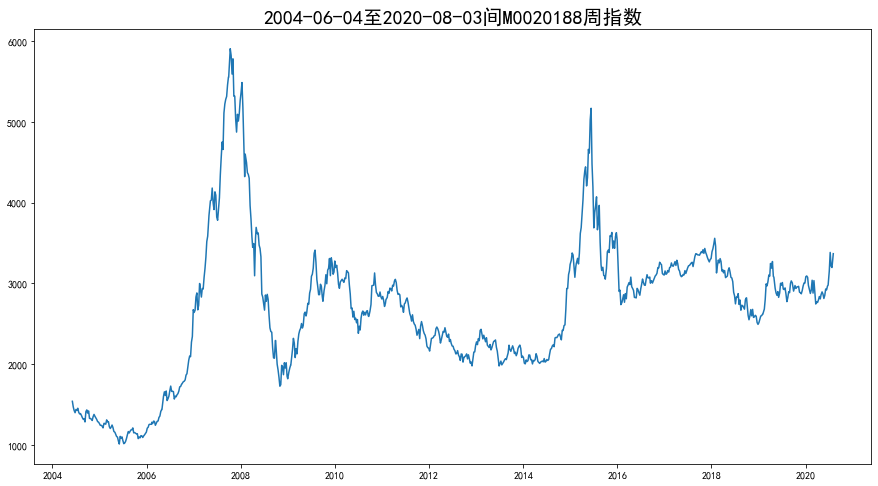

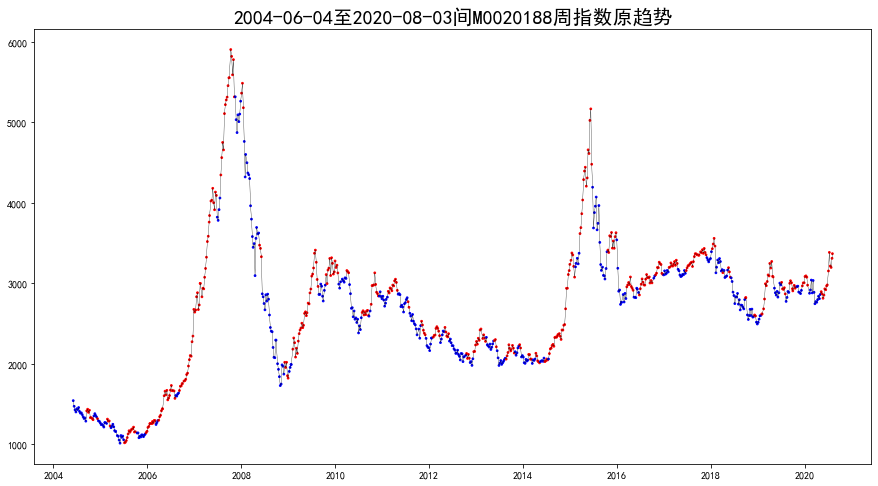

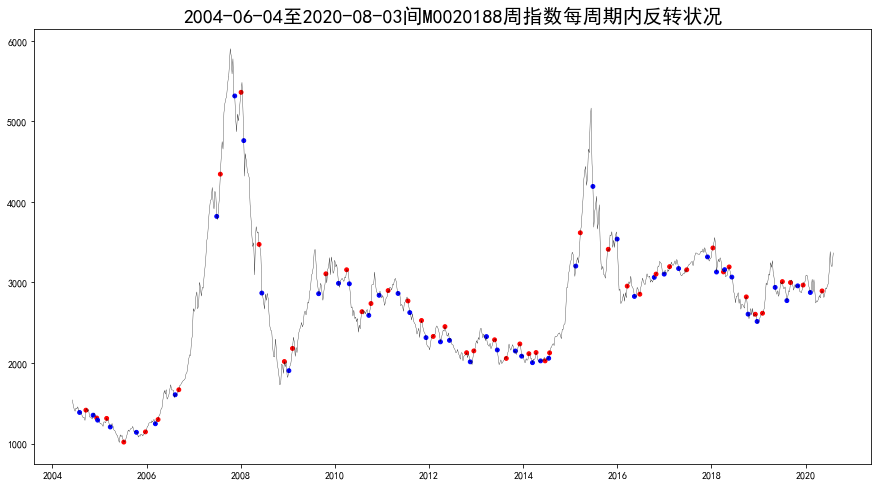

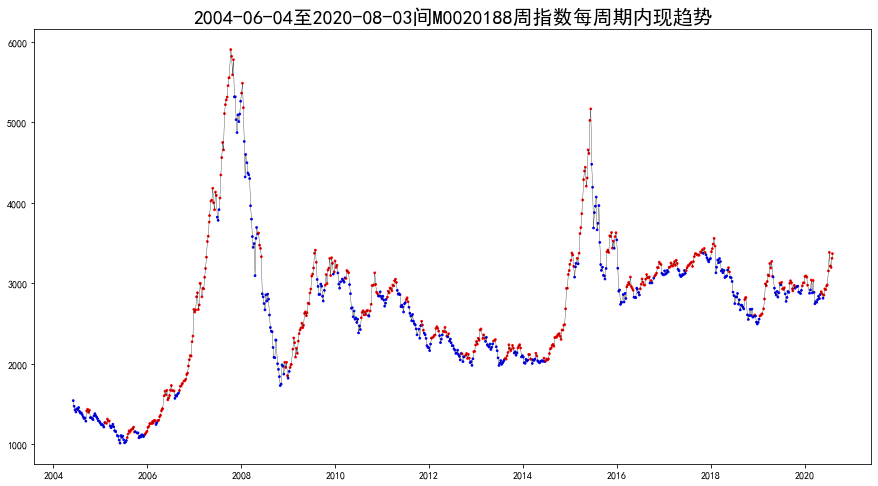

M0020188 第一次现趋势修正占比= 0.178


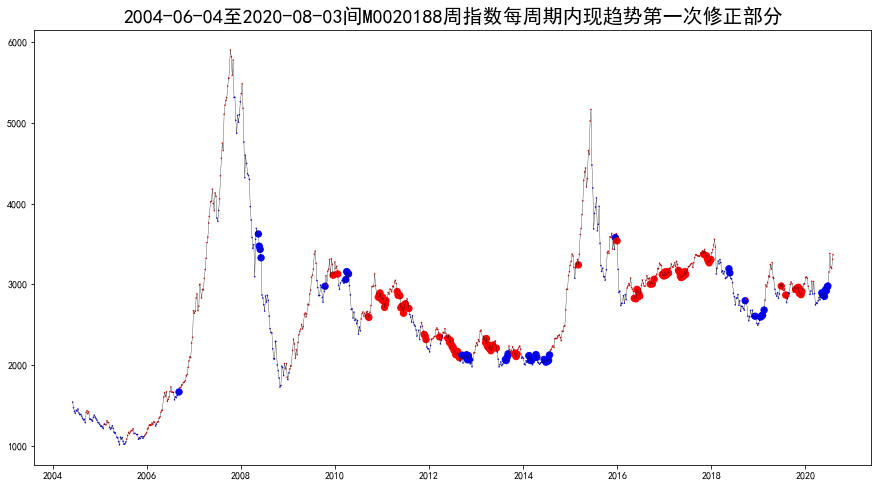

M0020188 第二次现趋势修正占比= 0.006


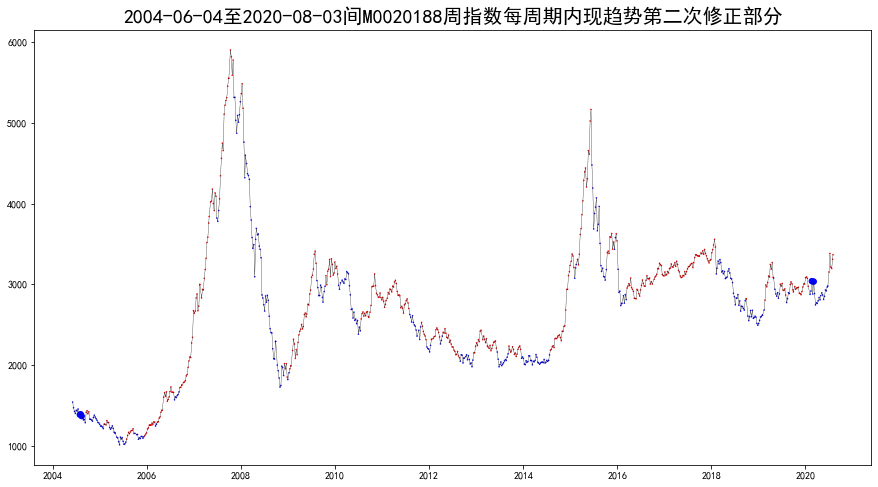

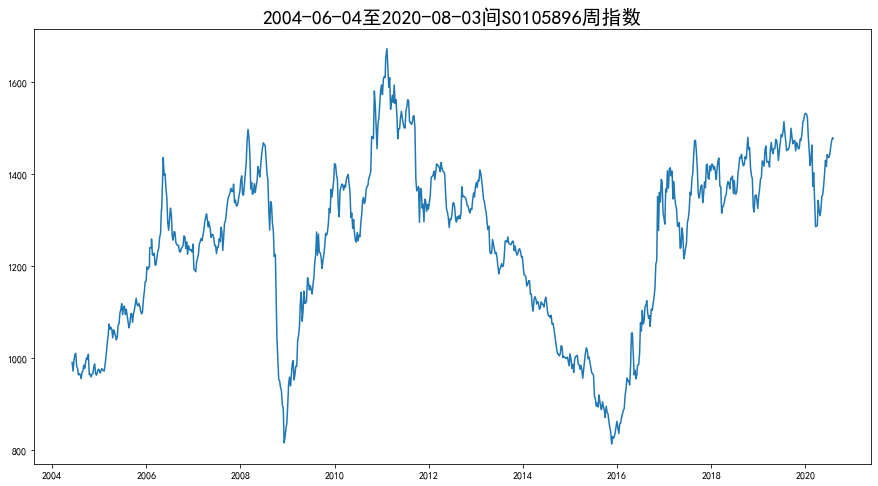

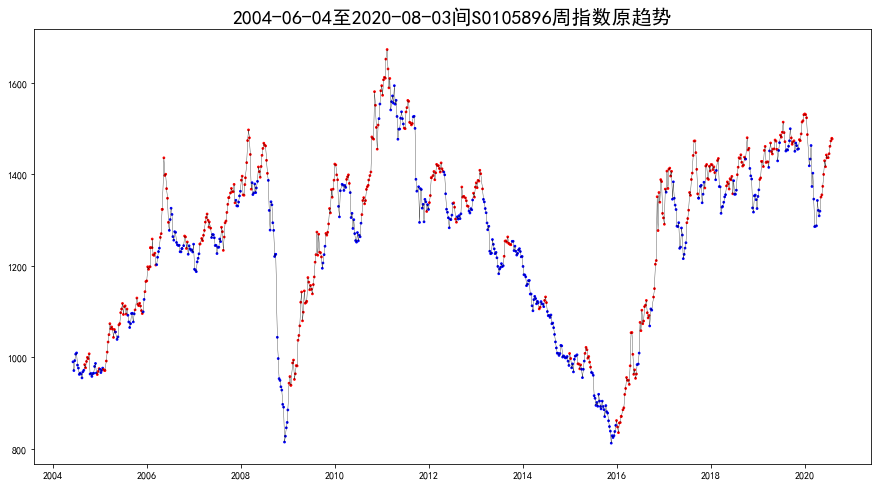

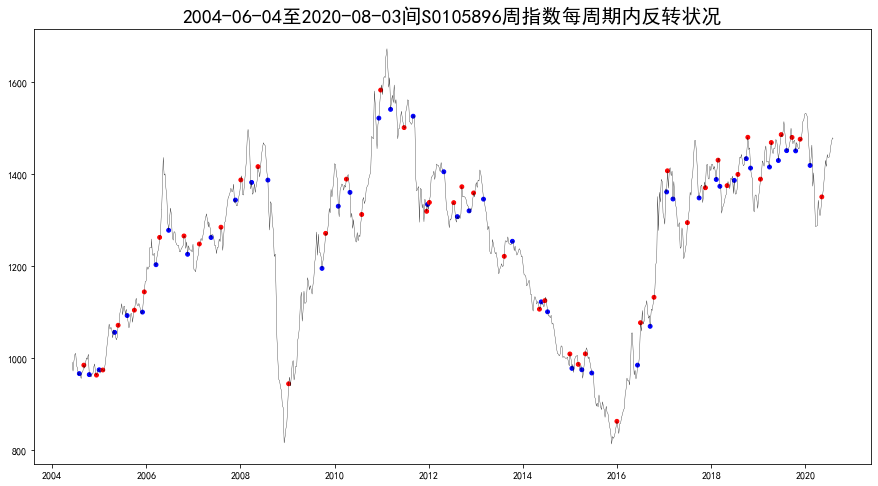

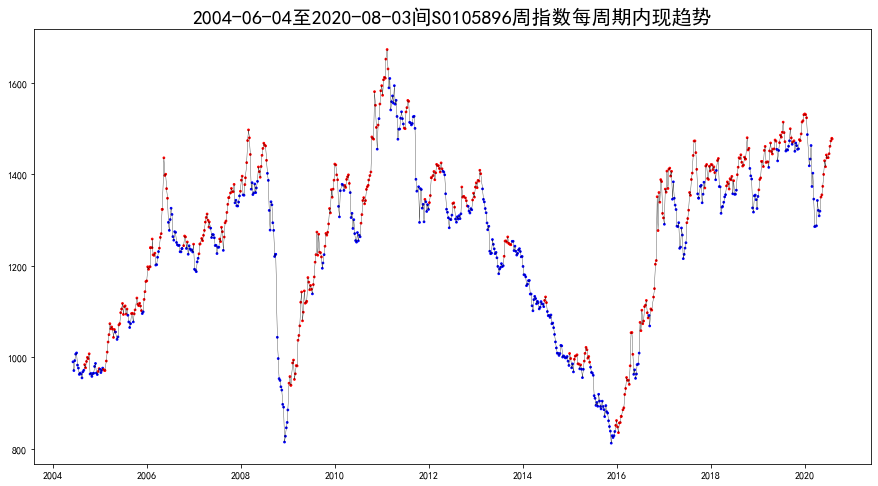

S0105896 第一次现趋势修正占比= 0.082


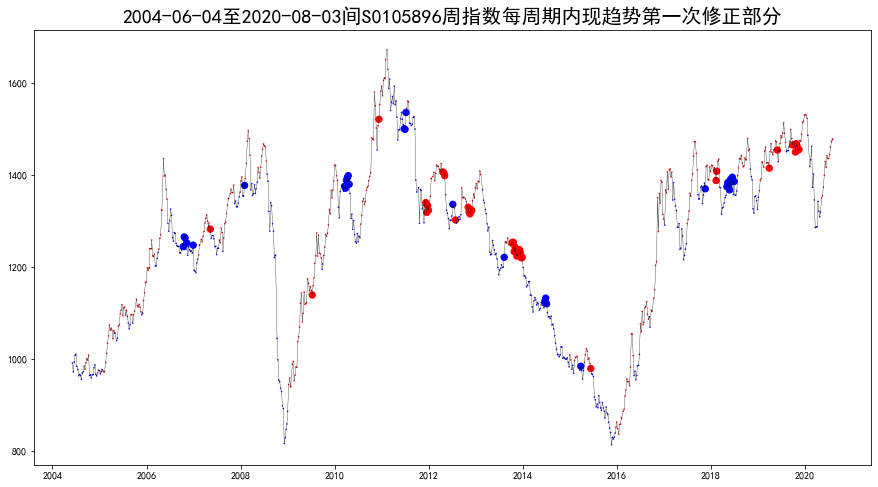

S0105896 第二次现趋势修正占比= 0.008


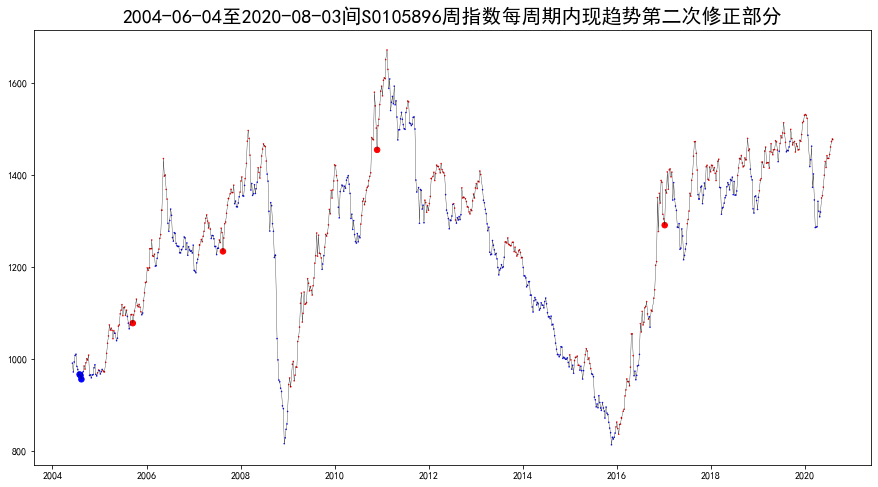

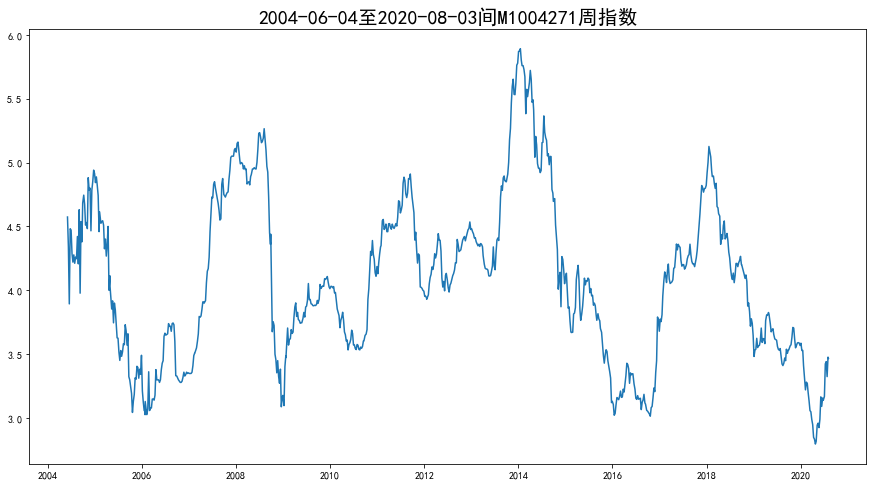

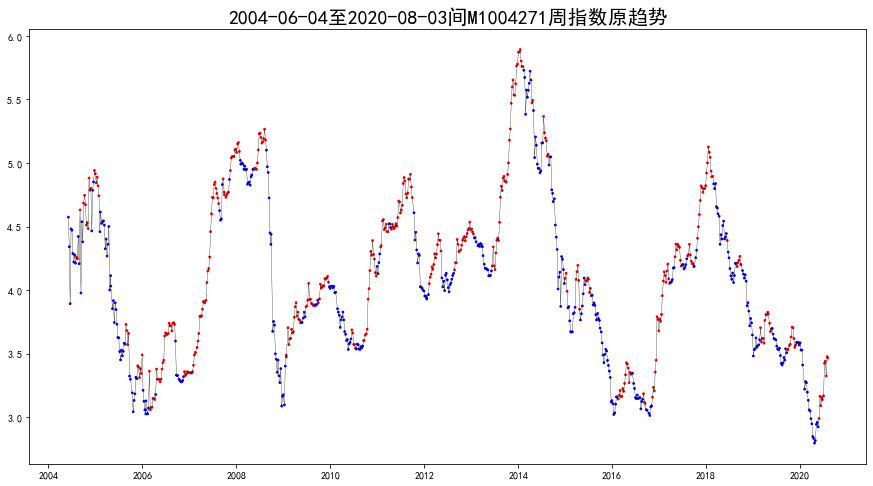

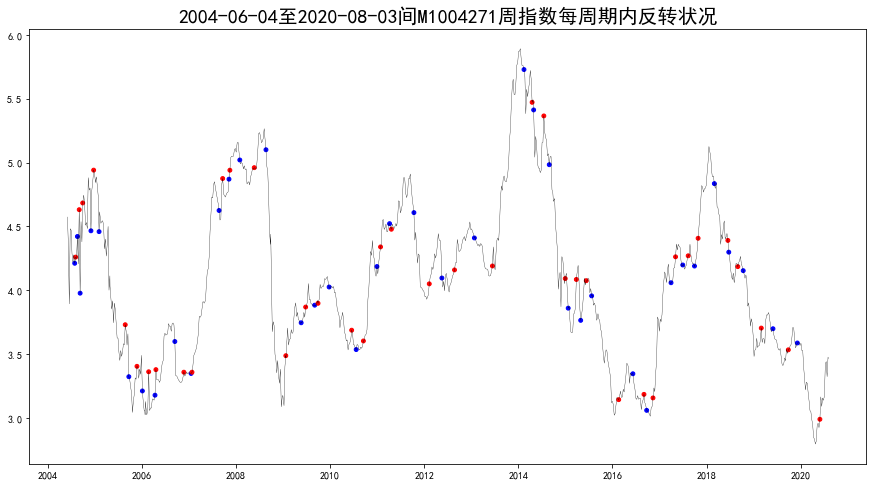

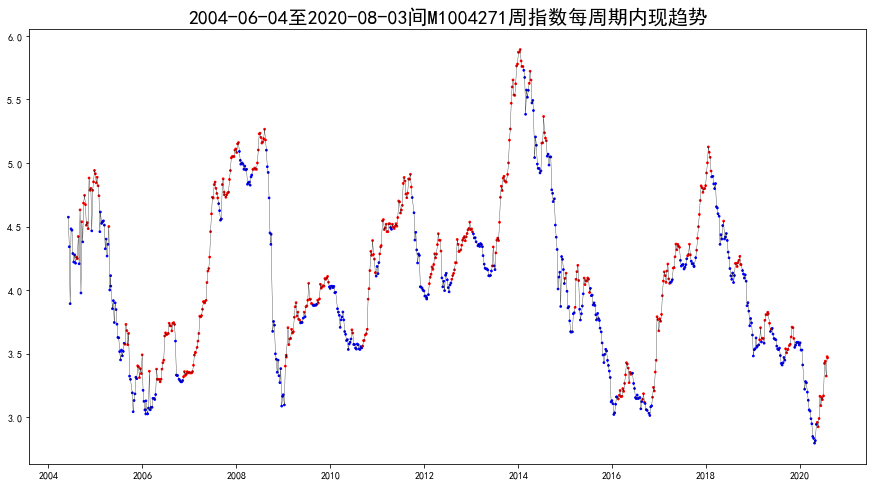

M1004271 第一次现趋势修正占比= 0.007


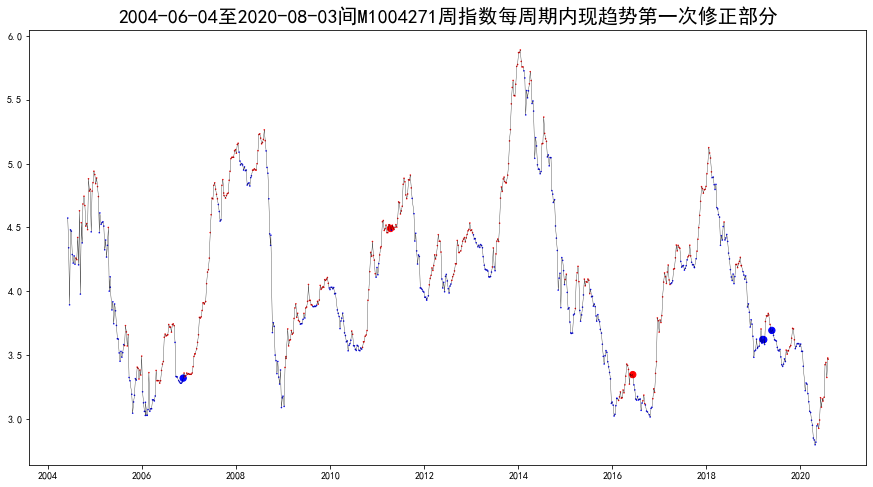

M1004271 第二次现趋势修正占比= 0.014


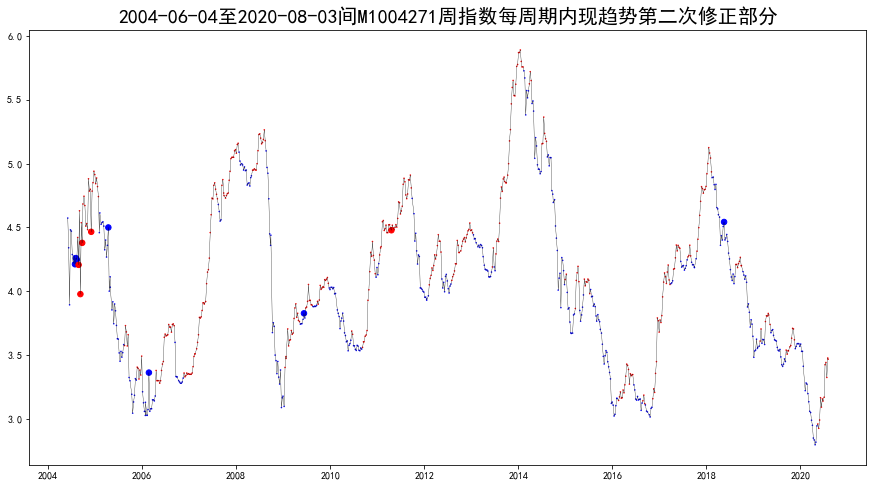

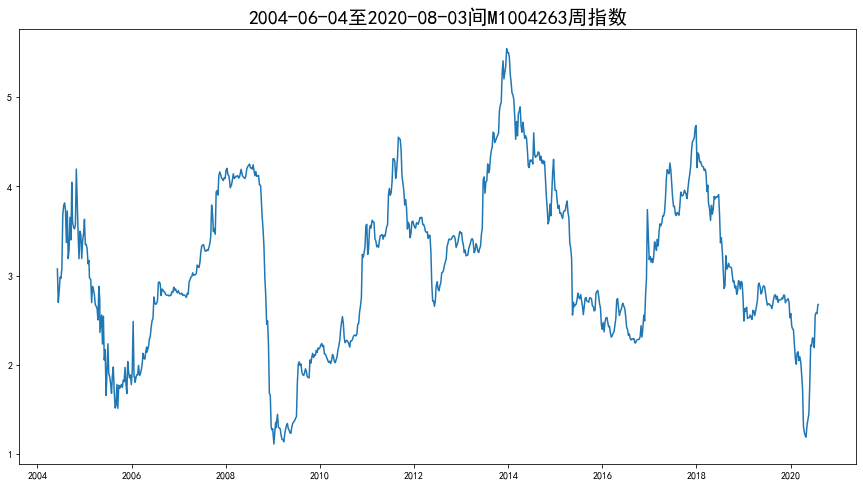

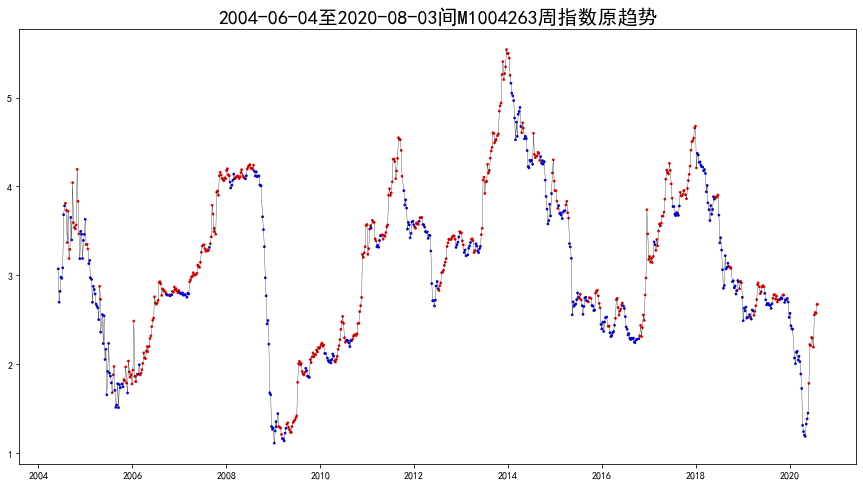

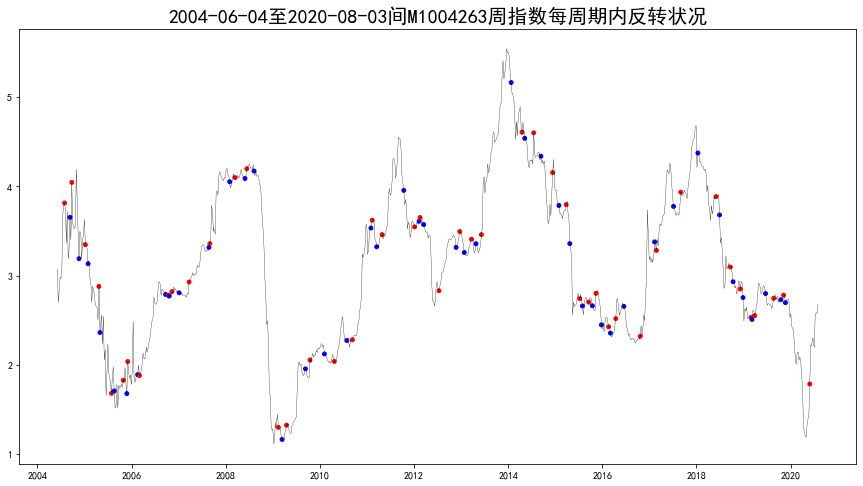

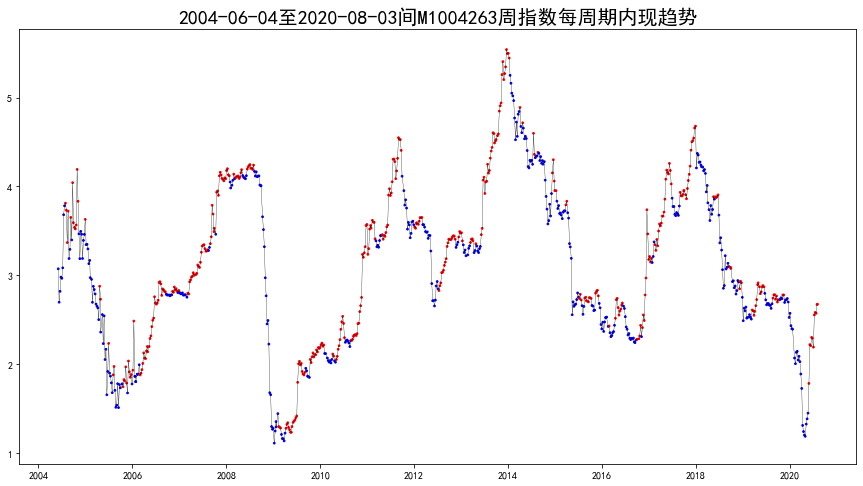

M1004263 第一次现趋势修正占比= 0.007


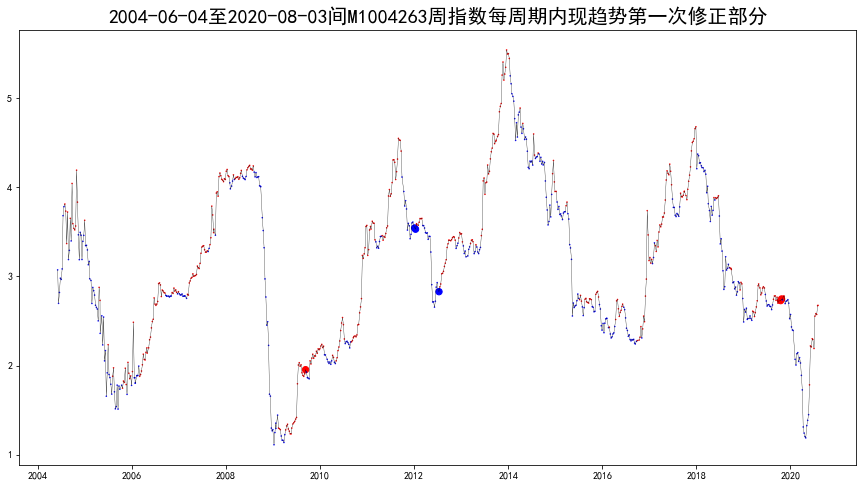

M1004263 第二次现趋势修正占比= 0.023


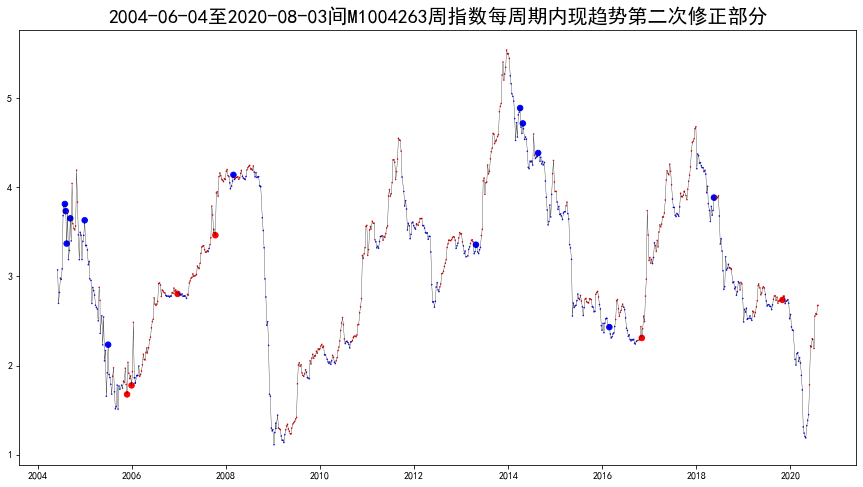

In [3]:
trend = mod(int_list, t0, t1, prd, itv, itv2, itv3, dic_market, n, pt)
date = w.wsd(int_list[0][0], 'close', t0, t1, Period = prd, Fill = 'Previous').Times

In [13]:
result = []

for i in range(len(date)):
    result.append(plg(trend[0][i],trend[1][i],trend[2][i]))
ind_list = []

for i in int_list:
    ind_list.append(i[0])
    
df = w.wsd(ind_list, 'close', t0, t1, Period = prd, Fill = 'Previous')

data = df.Data
date = df.Times

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

NameError: name 'collections' is not defined

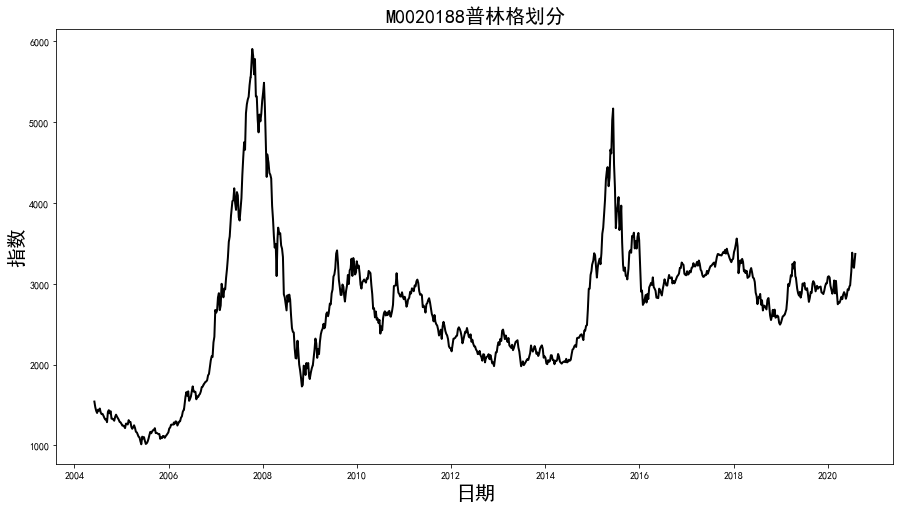

In [15]:
for i in range(len(data)):

    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_title(ind_list[i]+'普林格划分',fontproperties='SimHei', size = 20)
    ax.plot(date, data[i], color='black', linewidth = 2, label = '真实指数')
    plt.xlabel(u'日期',fontproperties='SimHei',fontsize = 20)
    plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

    new_legends = ["-", "-", "-", '-', '-', '-', '-']
    markers = ['-', '-','-', '-', '-', '-', '-']
    col = ['black', 'brown', 'red', 'orange', 'gold', 'yellow', 'grey']

    collection = collections.BrokenBarHCollection.span_where(
        date, ymin=0, ymax=max(data[i])*1.5, where=np.array(result) == 1, facecolor='brown', alpha=.2, label = '阶段1')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
        date, ymin=0, ymax=max(data[i])*1.5, where=np.array(result) == 2, facecolor='red', alpha=.2, label = '阶段2')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
        date, ymin=0, ymax=max(data[i])*1.5, where=np.array(result) == 3, facecolor='orange', alpha=.2, label = '阶段3')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
        date, ymin=0, ymax=max(data[i])*1.5, where=np.array(result) == 4, facecolor='gold', alpha=.2, label = '阶段4')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
        date, ymin=0, ymax=max(data[i])*1.5, where=np.array(result) == 5, facecolor='yellow', alpha=.2, label = '阶段5')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
        date, ymin=0, ymax=max(data[i])*1.5, where=np.array(result) == 6, facecolor='grey', alpha=.2, label = '阶段6')
    ax.add_collection(collection)

    _, labels = ax.get_legend_handles_labels()

    duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
    ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

    plt.show()
